In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.circuit import ParameterVector

In [2]:
import warnings
# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore')

In [3]:
#Load the dataset
import pandas as pd
# Read the text file
with open('AIDS_A.txt', 'r') as file:
    lines = file.readlines()
# Split the lines into separate columns based on comma delimiter
data = [line.strip().split(',') for line in lines] 
edge = pd.DataFrame(data, columns=['node1', 'node2'])
#Read the text file
graph_ind = pd.read_csv("AIDS_graph_indicator.txt",names=['graph'])
# Read the text file
with open('AIDS_node_attributes.txt', 'r') as file:
    lines = file.readlines()
# Split the lines into separate columns based on comma delimiter
data = [line.strip().split(',') for line in lines] 
node_feat = pd.DataFrame(data, columns=['atom', 'charge','x','y'])

In [4]:
#Relabel edges
edge = edge.astype(int)
edge = edge.applymap(lambda x: x + 1)

In [5]:
#Create node_id column for node features and graph indices data set
node_feat['node_id']=node_feat.index
graph_ind['node_id']=graph_ind.index

In [6]:
# Merge graph_ind and node_feat data frames
combined_df = pd.merge(graph_ind, node_feat, on='node_id')
# Group by graph_id and collect node features for each graph
topology_df = combined_df.groupby('graph').apply(lambda x: sorted(list(zip(x['node_id'], x[['atom','charge','x', 'y']].values)))).reset_index(name='topology')
topology_df.head(3)

,graph,topology
0,1,"[(0, [1.0, 0.0, 9.776700019836426, -3.54900..."
1,2,"[(47, [4.0, 0.0, 2.865999937057495, -0.4329..."
2,3,"[(58, [1.0, 0.0, 4.598100185394287, 0.75]),..."


In [7]:
import numpy as np
# Function to generate adjacency matrix for a given topology
def generate_adjacency_matrix(topology):
    num_nodes = len(topology[0])
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        start_node_id, start_node_feat = topology[0][i][0], list(topology[0][i][1])
        for j in range(i+1, num_nodes):
            end_node_id, end_node_feat = topology[0][j][0], list(topology[0][j][1])
            if (start_node_id,end_node_id) in edge.values or (end_node_id, start_node_id) in edge.values:
                adj_matrix[i][j] = adj_matrix[j][i] = 1
    return adj_matrix

In [8]:
#There are too many graphs, so sample a subset.
sampled_topology_df = topology_df[['topology']].sample(frac=0.1).reset_index(drop=True)  # Adjust the fraction as needed
#Want to add adjacency matrices for each of the graph topology
sampled_topology_df['adj']=sampled_topology_df[['topology']].apply(generate_adjacency_matrix, axis=1)

In [9]:
sampled_topology_df.head(3)

,topology,adj
0,"[(22596, [1.0, 0.0, 2.0, -0.25]), (22597, [...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, ..."
1,"[(14428, [2.0, 0.0, 3.0878000259399414, 0.9...","[[0, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, ..."
2,"[(27663, [2.0, 0.0, 14.34939956665039, -1.0...","[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [ ]:
sampled_topology_df['adj'].apply(len).sort_values().to_list()

In [10]:
#Focus on 6-nodes graphs
sampled_topology_df[sampled_topology_df['adj'].apply(len)==6]

,topology,adj
42,"[(19303, [5.0, 0.0, 2.809000015258789, 1.26...","[[0, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1], [1, 1..."
151,"[(22417, [6.0, 0.0, 2.0, -0.318399995565414...","[[0, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1], [1, 1..."
191,"[(4659, [1.0, 0.0, 3.865999937057495, 0.0])...","[[0, 1, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1], [1, 1..."


In [11]:
#Focus on 6x6 matrices
def generate_df(sample,nv):
    sample_filtered = sample[sample['adj'].apply(lambda x: len(x) == nv)]
    # Get the two most frequent topologies
    sample_filtered['adj_tuple'] = sample_filtered['adj'].apply(lambda x: tuple(map(tuple, x)))
    top2_freq = sample_filtered['adj_tuple'].value_counts().nlargest(2).index.tolist()
    print(sample_filtered['adj_tuple'].value_counts())
    top=sample_filtered[['topology']]
    A=sample_filtered[['adj']].iloc[0]['adj']
    return A,top
#Number of nodes
Nv = 6
A,top=generate_df(sampled_topology_df,Nv)

((0, 1, 1, 1, 1, 1), (1, 0, 1, 1, 1, 1), (1, 1, 0, 1, 1, 1), (1, 1, 1, 0, 1, 1), (1, 1, 1, 1, 0, 1), (1, 1, 1, 1, 1, 0))    3
Name: adj_tuple, dtype: int64


In [12]:
#Now starts QC part. For different dimensions, 
# Create a quantum circuit with Nv qubits
import pennylane as qml
from qiskit.circuit import Parameter
#Number of training samples
#n_samples=len(sampled_topology_df_filtered_5b5)
#Number of features
n_features=4
#Number of qubits
num_qubits = Nv * n_features  
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = np.random.random(size=(num_params))
#Extract 2d features from 'topology' column
def extract_features(row):
    feature_vectors = [feat for _, feat in row[0]]
    return np.array(feature_vectors)
# Apply the function to each row of the DataFrame and convert the result into a numpy array
Xs = np.array(top.apply(extract_features, axis=1).tolist())
Xs = Xs.reshape(Xs.shape[0], -1).astype(float)

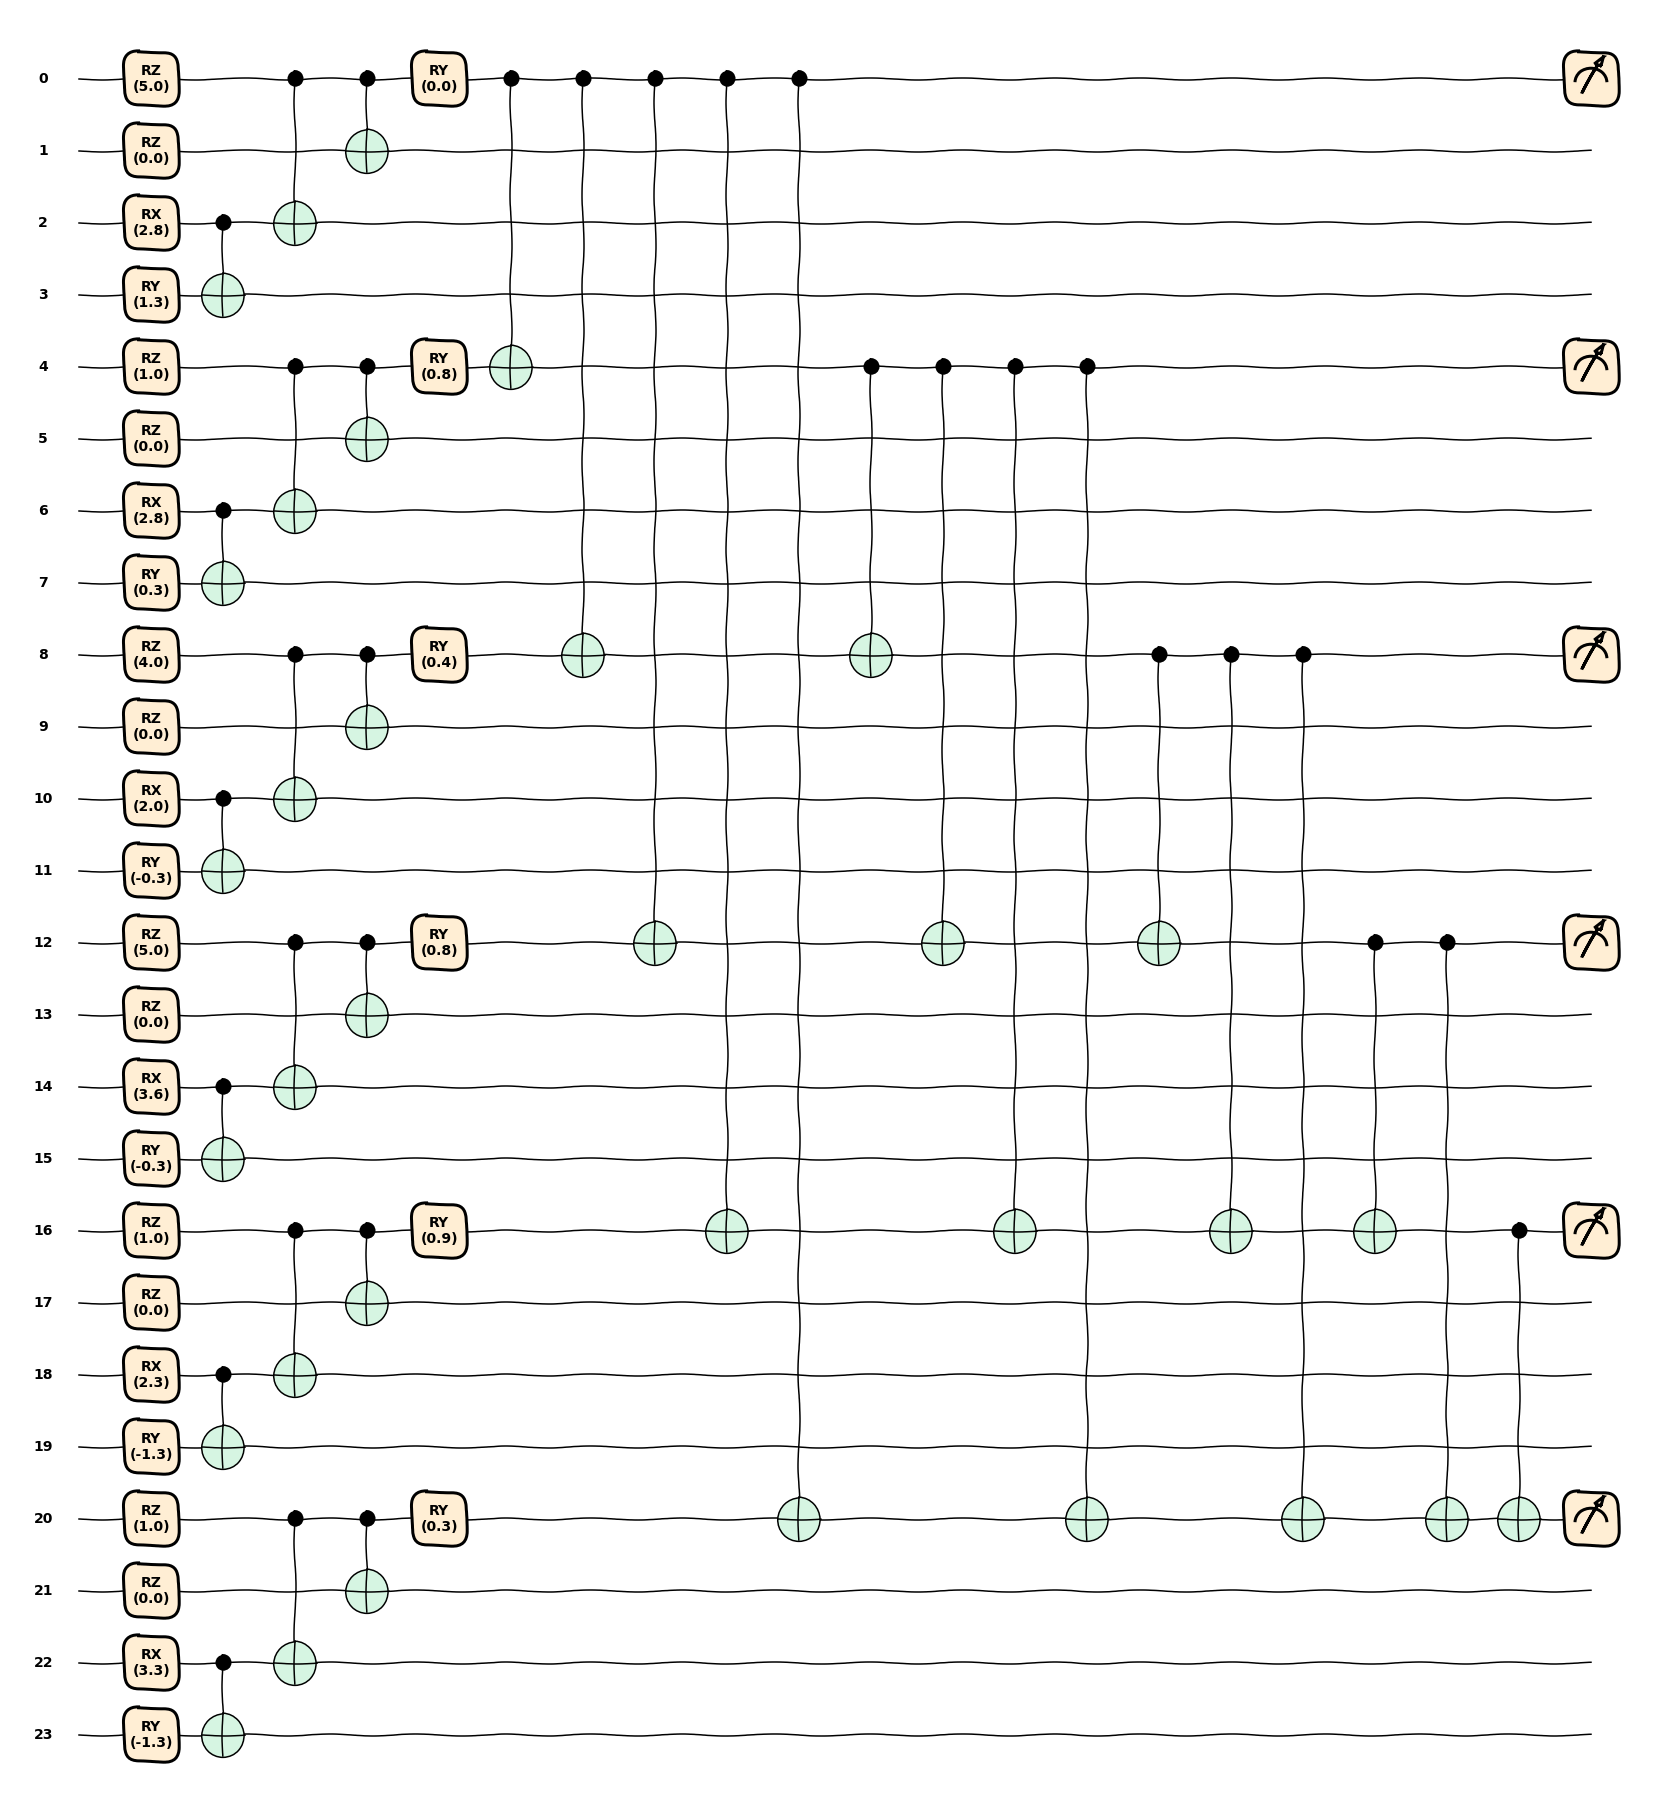

In [13]:
import matplotlib.pyplot as plt
#For QC display
def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(n_features):
                if j==0:
                    qml.RZ(X[i*n_features+j], wires = i * n_features + j)
                elif j==1:
                    qml.RZ(X[i*n_features+j], wires = i * n_features + j)
                elif j==2:
                    qml.RX(X[i*n_features+j], wires = i * n_features + j)
                elif j==3:
                    qml.RY(X[i*n_features+j], wires = i * n_features + j)
            #Entangle features
            qml.CNOT(wires = [i * n_features+2, i *n_features + 3])
            qml.CNOT(wires = [i * n_features, i *n_features + 2])
            qml.CNOT(wires = [i * n_features, i *n_features + 1])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * n_features)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    qml.CNOT(wires = [i * n_features, j * n_features])
        samples = [qml.sample(qml.PauliZ(i * n_features)) for i in range(Nv)]
        return tuple(samples)        
dev = qml.device("default.qubit", wires=n_features*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],ansatz)
plt.show()

In [14]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*n_features, shots=100)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(n_features):
                if j==0:
                    qml.RZ(X[i*n_features+j], wires = i * n_features + j)
                elif j==1:
                    qml.RZ(X[i*n_features+j], wires = i * n_features + j)
                elif j==2:
                    qml.RX(X[i*n_features+j], wires = i * n_features + j)
                elif j==3:
                    qml.RY(X[i*n_features+j], wires = i * n_features + j)
            #Entangle features
            qml.CNOT(wires = [i * n_features+2, i *n_features + 3])
            qml.CNOT(wires = [i * n_features, i *n_features + 2])
            qml.CNOT(wires = [i * n_features, i *n_features + 1])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * n_features)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * n_features, j * n_features])
        samples = [qml.sample(qml.PauliZ(i * n_features)) for i in range(Nv)]
        return tuple(samples)         
    x = quantum_circuit(X, ansatz)
    y = [[x[j][i] for j in range(Nv)] for i in range(len(x[0]))]
    return y

In [15]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*n_features, shots=100)
@qml.qnode(dev)
def measure(X,ansatz):
    x = quantum_circuit(X, ansatz)
    return x
def transform(x):
    y = [[x[j][i] for j in range(Nv)] for i in range(100)]
    return y
def minus_to_zero(y):
    for j in range(len(y)):
        for i in range(Nv):
            if y[j][i]<0:
                y[j][i]=0
    return y
X=Xs[0]
result=minus_to_zero(transform(measure(X,ansatz)))

In [16]:
#Collect measurement results from 100 samples
results=[]
for X in Xs:
    result=minus_to_zero(transform(measure(X,ansatz)))
    results.extend(result)

In [17]:
#Plotting tool
def plot_result(measurements,tf):
    # Convert each sublist in y to a binary string and create a list of binary strings
    binary_strings = [''.join(map(str, sublist)) for sublist in result]
    unique_binary_strings, counts = np.unique(binary_strings, return_counts=True)
    # Plotting the histogram
    plt.bar(unique_binary_strings, counts, edgecolor='black')
    # Adding labels and title
    plt.xlabel('Results')
    plt.ylabel('Frequency')
    if tf=='T':
        plt.title(str(Nv)+'-qubits measurement for true '
                  +str(Nv)+'-nodes graph')
    else:
        plt.title(str(Nv)+'-qubits measurement for fake '
                  +str(Nv)+'-nodes graph')
    # Display the plot
    plt.show()

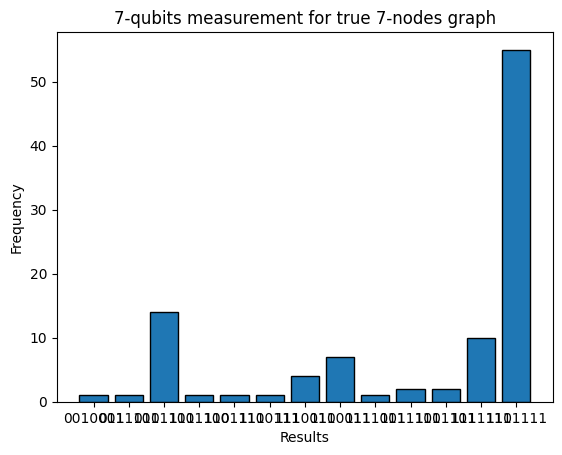

In [86]:
#Show results for the 7-node.
plot_result(results,'T')

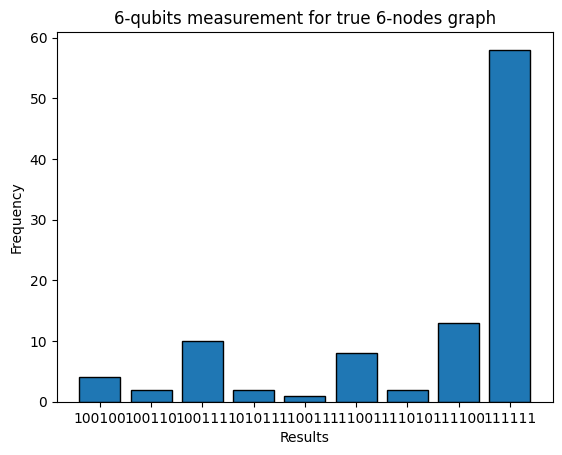

In [18]:
#Show results for the 6-node.
plot_result(results,'T')